In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
import time
from matplotlib import rc

In [2]:
class funcODE_PINN:
    # Initialize the class
    def __init__(self, x_u, u, x_f, gov_eqn, layers, lyscl, lb, ub, gamma):
        
        self.x_u = x_u
        self.u = u
        self.x_f = x_f
        
        self.lb = lb
        self.ub = ub
                
        self.layers = layers
        self.lyscl = lyscl
        self.lw = gamma
        
        self.data_type = x_f.dtype
        
        self.gov_eqn = gov_eqn
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers, lyscl)

        
        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be 
        #            automatically updated in the original tf.Variable
        
        # define the loss function
        self.loss = self.loss_NN()[0]
        
        self.optimizer_Adam = tf.optimizers.Adam()

    
    '''
    Functions used to establish the initial neural network
    ===============================================================
    '''
    
    def initialize_NN(self, layers, lyscl):        
        weights = []
        biases = []
        num_layers = len(layers)       
        for l in range(0,num_layers-1):
            W = self.MPL_init(size=[layers[l], layers[l+1]], lsnow=lyscl[l])                
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=self.data_type))
            weights.append(W)
            biases.append(b)  
        return weights, biases
    
    
    def MPL_init(self, size, lsnow):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim)) * lsnow
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.data_type))
    
    
    '''
    Functions used to building the physics-informed contrainst and loss
    ===============================================================
    '''
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y


    def net_u(self, x):
        u = self.neural_net(x, self.weights, self.biases)
        return u
    
    
    def net_f(self, x):
        f = self.gov_eqn(x, self.net_u)
        return f
    
    
    # calculate the physics-informed loss function
    def loss_NN(self):
        self.u_pred = self.net_u(self.x_u) 
        self.f_pred = self.net_f(self.x_f)  
        
        loss_d = tf.reduce_mean(tf.square(self.u - self.u_pred))
        loss_e = tf.reduce_mean(tf.square(self.f_pred))
        
        loss = loss_d + self.lw * loss_e
        return loss, loss_d, loss_e
    
    

    def net_u_test(self, x):
        u_ts = self.net_u(x) + self.r0 * self.net_f(x)    
        return u_ts
    
    
    def net_f_test(self, x, epsil):
        self.r0 = epsil  
        f_ts = self.gov_eqn(x, self.net_u_test)
        return f_ts
    
   
    
    '''
    Functions used to define ADAM optimizers
    ===============================================================
    '''
    # define the function to apply the ADAM optimizer
    def Adam_optimizer(self, nIter):
        varlist = self.train_variables
        start_time = time.time()
        for it in range(nIter):
            self.optimizer_Adam.minimize(self.loss_NN, varlist)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.loss_NN()[0]
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                
                
    '''
    Functions used to define L-BFGS optimizers
    ===============================================================
    '''
    
    # A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    def Lbfgs_function(self, varlist):
        # obtain the shapes of all trainable parameters in the model
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)
    
        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = [] # stitch indices
        part = [] # partition indices
        
        self.start_time = time.time()
    
        for i, shape in enumerate(shapes):
            n = np.product(shape)
            idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
            part.extend([i]*n)
            count += n
    
        part = tf.constant(part)
        
        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self
            
            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                varlist[i].assign(tf.reshape(param, shape))
                
                
        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self
    
            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model 
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_value, loss_d, loss_e = self.loss_NN()

    
            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_value, varlist)
            grads = tf.dynamic_stitch(idx, grads)
    
            # store loss value so we can retrieve later
            tf.py_function(f.history.append, inp=[loss_value], Tout=[])
                
            # print out iteration & loss
            f.iter.assign_add(1)
            
            if f.iter % 10 == 0:
                tf.print("Iter:", f.iter, "loss:", loss_value,
                         "loss_d:", loss_d, "loss_e:",loss_e)
                
            return loss_value, grads
        
        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.history = []
        
        return f
    
    
    # define the function to apply the L-BFGS optimizer
    def Lbfgs_optimizer(self, nIter):
        varlist = self.train_variables
        func = self.Lbfgs_function(varlist)
    
        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, varlist)
        
        max_nIter = tf.cast(nIter/3, dtype = tf.int32)
    
        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params, 
            tolerance=10e-9, max_iterations=max_nIter)
    
        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)
        
        
    '''
    Function used for training the model
    ===============================================================
    '''
        
    def train(self, nIter, idxOpt):
        if idxOpt == 1:
            # mode 1: running the Adam optimization
            self.Adam_optimizer(nIter)
        elif idxOpt == 2:
            self.Lbfgs_optimizer(nIter)
            
        
    def predict(self, x):
        u_p = self.net_u(x)
        f_p = self.net_f(x)  
        return u_p, f_p
    
    


# define the decorator for calculating the derivative with x
def fwgradient(func):
    def wrapper(x):
        with tf.GradientTape() as tg:
            tg.watch(x) #must add watch(), since x is not tf.Variable
            U = func(x)
        g = tg.gradient(U,x)
        return g
    return wrapper   


# define the governing equation to solve
def gov_eqn(x, func_u):
    # using the decorator to define the batch jacobian        
    ux_func = fwgradient(func_u)

    u = func_u(x)    
    u_x = ux_func(x)
    f = u_x - u
    return f

In [3]:
'''
Define the hyper-parameter
============================================
'''
np.random.seed(1234)
tf.random.set_seed(1243)

N_f = 401
N_t = 101
layers = [1,20,1]
lyscl = [1,1]

data_type = tf.float32

'''
Define the problem
============================================
'''
x_train = tf.constant([0.], dtype=data_type)[:,None]
u_train = tf.constant([1.], dtype=data_type)[:,None]
x_star = np.linspace(0,2,N_f)[:,None]
u_star = np.exp(x_star)

# Doman bounds
lx = x_star.min()
ux = x_star.max()

'''
Conducting the first-round prediction
============================================
'''
x_f_train = np.linspace(lx,ux,N_t)[:,None]
x_f_train = lx + (ux-lx)*lhs(1, N_t)

x_f_train = np.vstack((x_f_train, x_train))
x_f_train = tf.cast(x_f_train, dtype=data_type)

gamma = 10

model = funcODE_PINN(x_train, u_train, x_f_train, gov_eqn, layers, lyscl, lx, ux, gamma)
start_time = time.time()        
model.train(30, 2)  # original iteration 10000
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

x_star = tf.cast(x_star, dtype=data_type)   
u_pred, f_pred = model.predict(x_star)

Iter: 10 loss: 1.03421474 loss_d: 0.768487155 loss_e: 0.0265727602
Iter: 20 loss: 0.902687311 loss_d: 0.824607551 loss_e: 0.0078079775
Iter: 30 loss: 0.897895217 loss_d: 0.695571721 loss_e: 0.0202323459
Training time: 1.2423


Text(0.5, 1.0, 'equation residue')

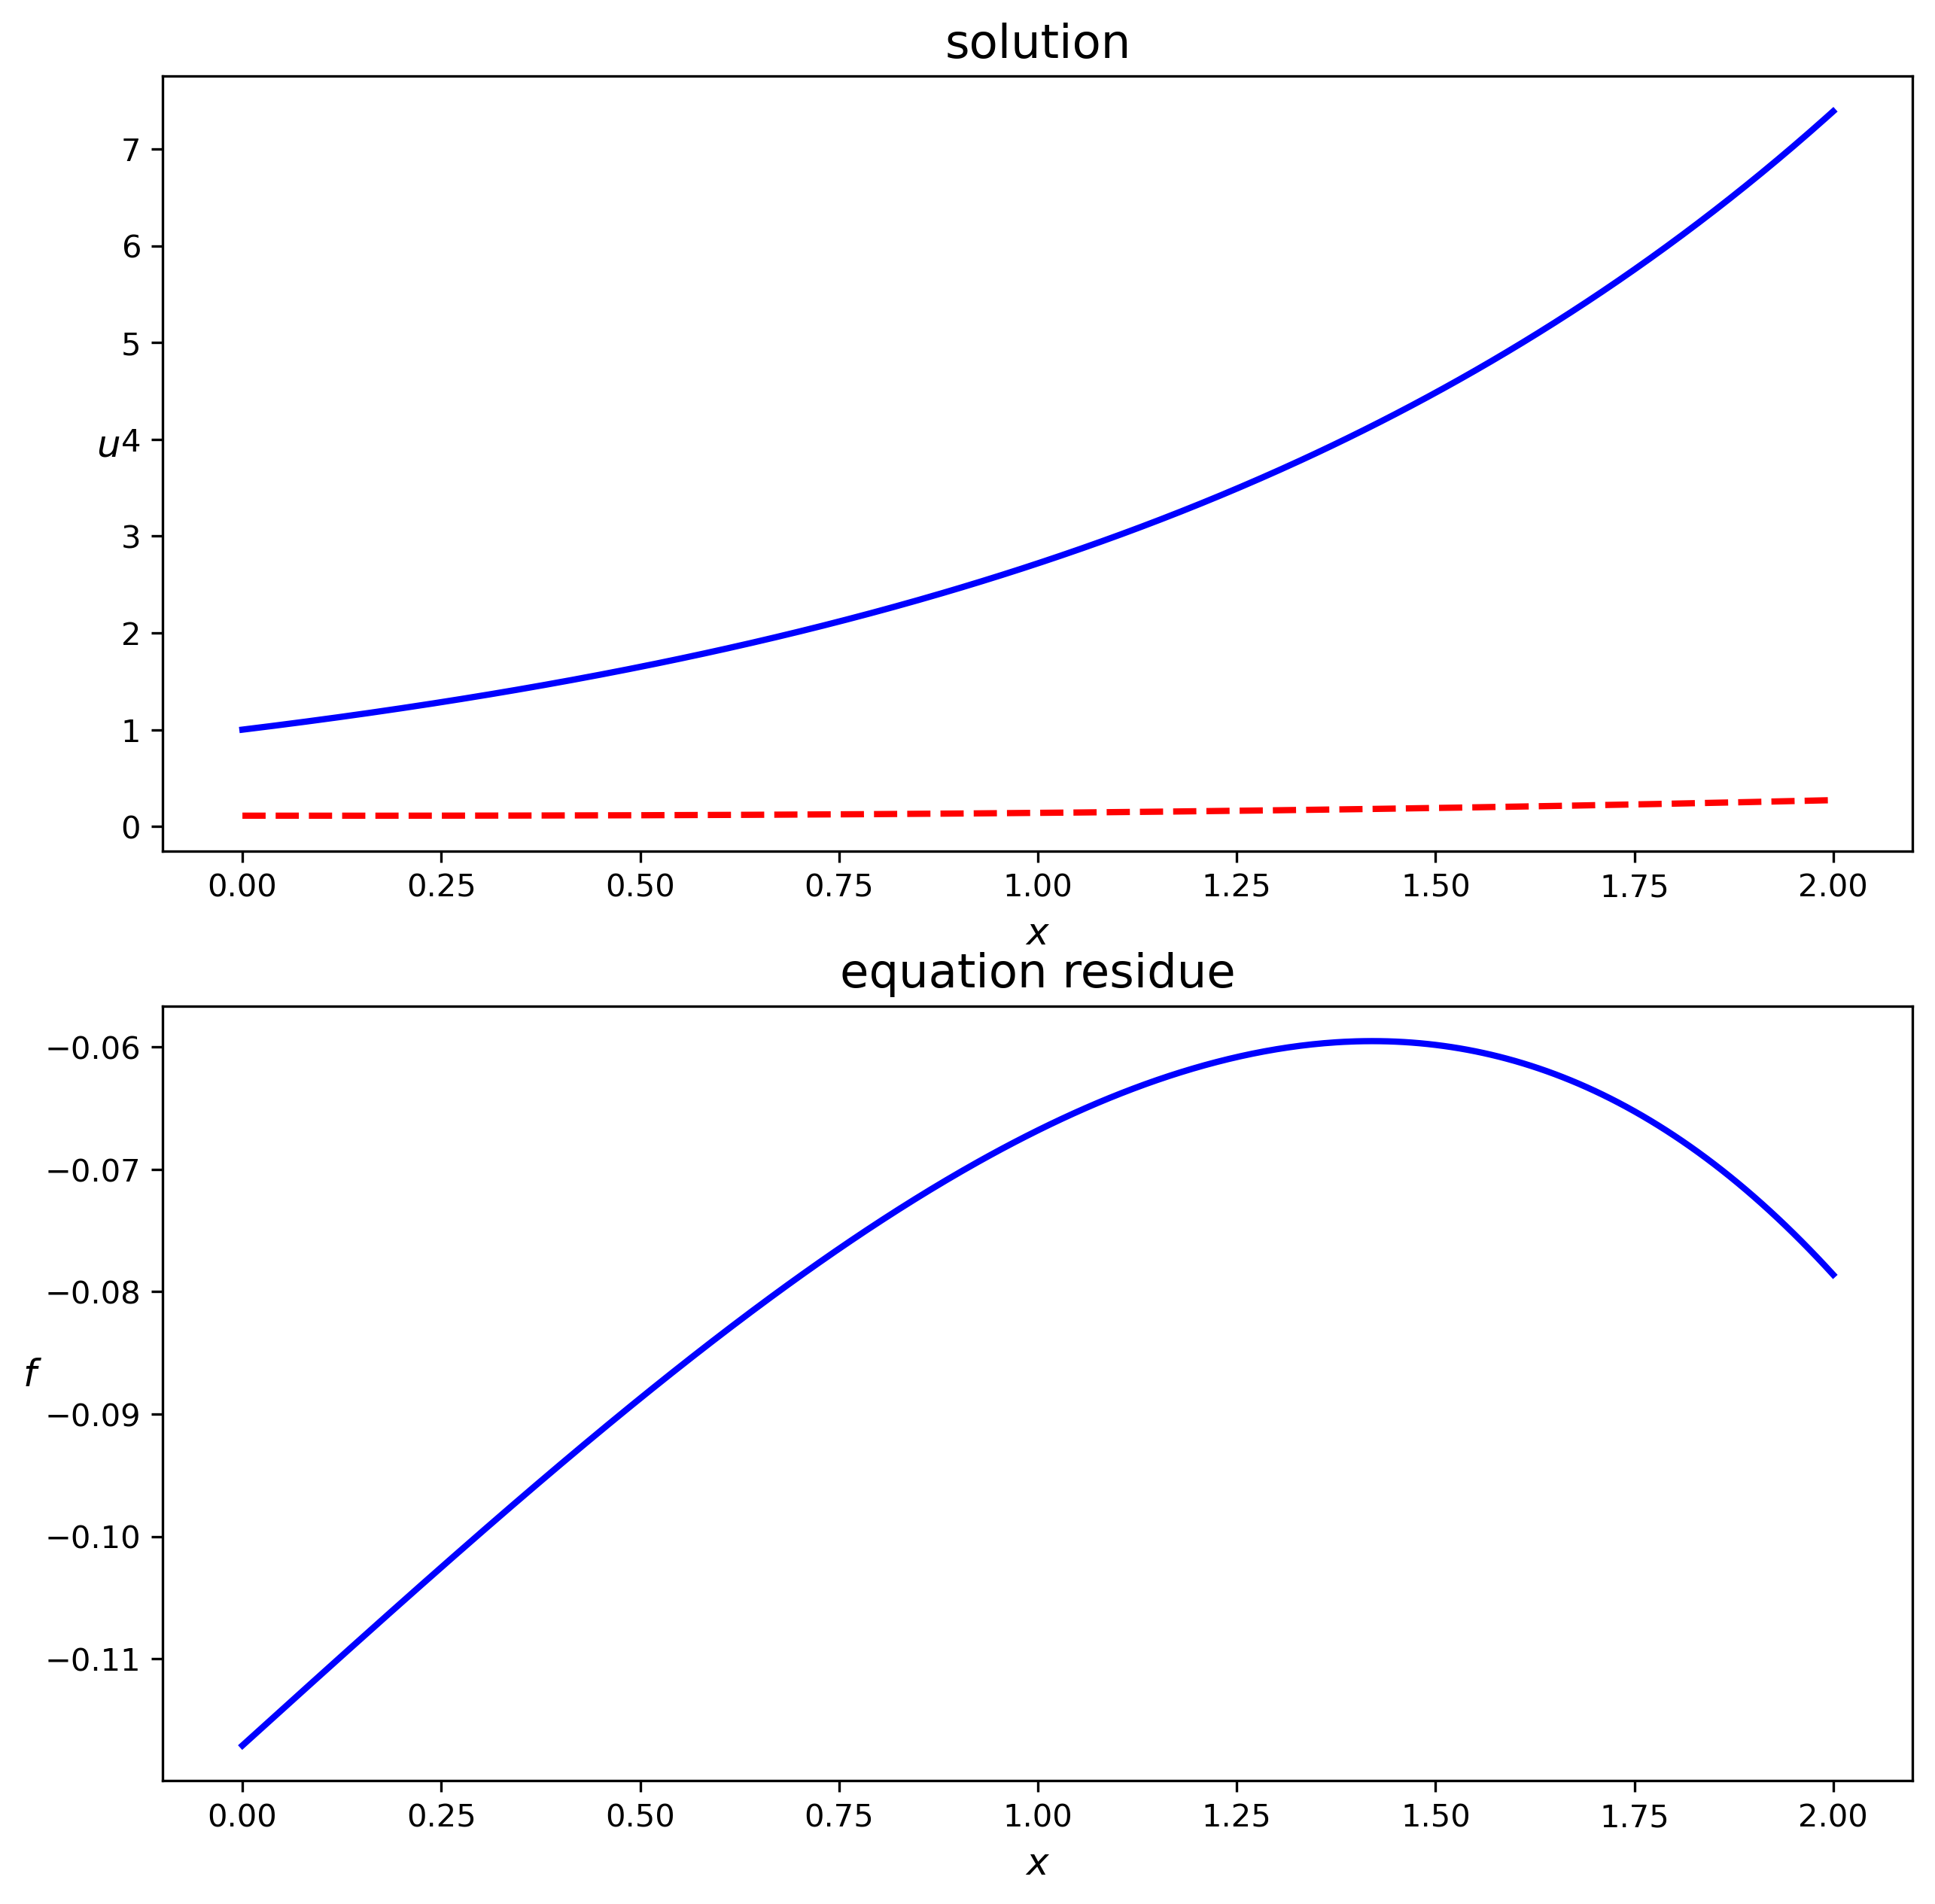

In [4]:
%matplotlib inline

######################################################################
############################# Plotting ###############################
######################################################################    

fig = plt.figure(figsize = [10, 10], dpi = 300)

ax = plt.subplot(211)
ax.plot(x_star, u_star, 'b-', linewidth = 2, label = 'exact')
ax.plot(x_star, u_pred, 'r--', linewidth = 2, label = 'predict')

ax.set_xlabel('$x$', fontsize = 12)
ax.set_ylabel('$u$', fontsize = 12, rotation = 0)
ax.set_title('solution', fontsize = 15)


ax = plt.subplot(212)
ax.plot(x_star, f_pred, 'b-', linewidth = 2)

ax.set_xlabel('$x$', fontsize = 12)
ax.set_ylabel('$f$', fontsize = 12, rotation = 0)
ax.set_title('equation residue', fontsize = 15)